In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import nltk

In [ ]:
!pip install torch==2.2.2 torchtext==0.17.2 torchvision==0.17.2 torchaudio==2.2.2

In [ ]:
netflix_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coursework/netflix_reviews.csv')

# Section 1: Text Data Selection and Preprocessing

In [ ]:
# inspect the dataset
print("Dataset shape:", netflix_reviews.shape)
print("Columns:", netflix_reviews.columns)
print(netflix_reviews.head())

# Create a binary sentiment label: positive if score >= 3, negative otherwise.
netflix_reviews['sentiment'] = (netflix_reviews['score'] >= 3).astype(int)

# Text Preprocessing using the 'content' column
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet') # Download WordNet for lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'[^\w\s!]+', '', text) # Remove punctuation except exclamation marks
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Lemmatize
    return ' '.join(tokens)

netflix_reviews['clean_review'] = netflix_reviews['content'].astype(str).apply(clean_text)
print("Cleaned review sample:")
print(netflix_reviews['clean_review'].head())

Dataset shape: (4999, 8)
Columns: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')
                               reviewId            userName  \
0  efd00499-5e00-49b5-9f32-bc7177ac5ca6     Mikel Magnusson   
1  be0d97e1-7de1-4f07-b493-35a53098b5a4       John McDevitt   
2  8970dbcd-d75f-4016-bb93-efa5de3ef9e6      Mayur Savaliya   
3  a288bc3c-8a90-42d3-b585-1c8078faa96c  Magdalena Glessing   
4  c388a806-0795-4812-b04e-5b2cdf327157    Elizabeth Turner   

                                             content  score  thumbsUpCount  \
0  Netfix Canada forced my wife into a screen tha...    1.0            0.0   
1  I use this app until it asks if I'm still ther...    2.0            0.0   
2                        Boycott Netflix from Bharat    1.0            1.0   
3  Little good movies and a lot of wonderful TV s...    5.0            0.0   
4  New to this but, so far smooth sailing.app is ...   

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cleaned review sample:
0    netfix canada forced wife screen would allow e...
1    use app asks im still move another service tha...
2                               boycott netflix bharat
3              little good movie lot wonderful tv show
4    new far smooth sailingapp easy usegreat select...
Name: clean_review, dtype: object


# Section 2: Deep Learning Model Implementation

In [ ]:
!pip install numpy

Epoch 1: Train Loss=0.5991, Val Loss=0.5726, Val Acc=0.6790
Epoch 2: Train Loss=0.5265, Val Loss=0.4960, Val Acc=0.7150
Epoch 3: Train Loss=0.4428, Val Loss=0.4237, Val Acc=0.7940
Epoch 4: Train Loss=0.3832, Val Loss=0.3828, Val Acc=0.8050
Epoch 5: Train Loss=0.3543, Val Loss=0.3636, Val Acc=0.8110
Epoch 6: Train Loss=0.3335, Val Loss=0.3464, Val Acc=0.8220
Epoch 7: Train Loss=0.3196, Val Loss=0.3346, Val Acc=0.8270
Epoch 8: Train Loss=0.3079, Val Loss=0.3214, Val Acc=0.8390
Epoch 9: Train Loss=0.2966, Val Loss=0.3107, Val Acc=0.8530
Epoch 10: Train Loss=0.2895, Val Loss=0.3010, Val Acc=0.8610
Epoch 11: Train Loss=0.2835, Val Loss=0.2966, Val Acc=0.8640
Epoch 12: Train Loss=0.2754, Val Loss=0.2926, Val Acc=0.8660
Epoch 13: Train Loss=0.2737, Val Loss=0.2865, Val Acc=0.8660
Epoch 14: Train Loss=0.2684, Val Loss=0.2855, Val Acc=0.8740
Epoch 15: Train Loss=0.2628, Val Loss=0.2787, Val Acc=0.8750
Epoch 16: Train Loss=0.2615, Val Loss=0.2774, Val Acc=0.8750
Epoch 17: Train Loss=0.2563, Val 

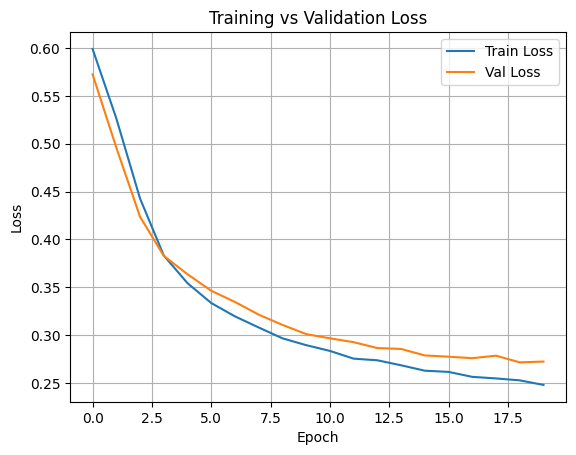

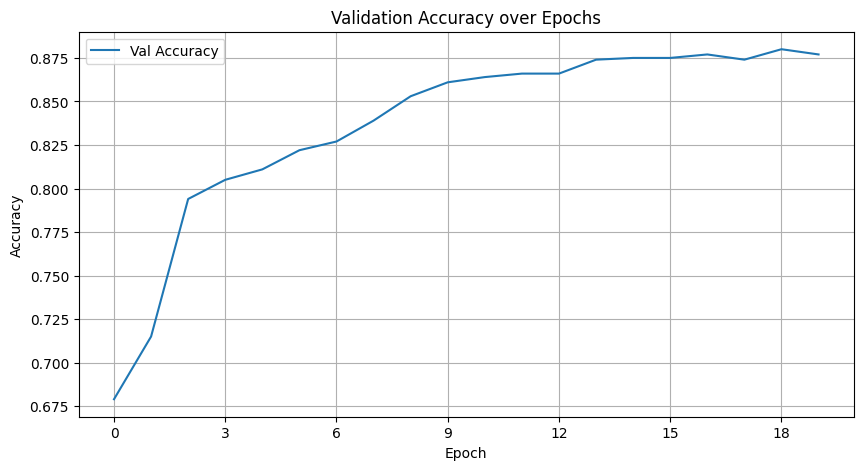

In [ ]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Tokenization and vocabulary creation
tokenizer = get_tokenizer("basic_english")
netflix_reviews['tokens'] = netflix_reviews['clean_review'].apply(tokenizer)

max_vocab = 10000
counter = Counter()
for tokens in netflix_reviews['tokens']:
    counter.update(tokens)

# Reserve indices for padding (<pad>) and unknown (<unk>)
vocab = {word: i + 2 for i, (word, _) in enumerate(counter.most_common(max_vocab))}
vocab['<unk>'] = 1
vocab['<pad>'] = 0

def tokens_to_indices(tokens):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

netflix_reviews['sequence'] = netflix_reviews['tokens'].apply(tokens_to_indices)

# Padding sequences
max_len = 100
netflix_reviews['padded'] = netflix_reviews['sequence'].apply(
    lambda seq: seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]
)

# Prepare data
X = np.array(netflix_reviews['padded'].tolist())
y = netflix_reviews['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

# BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, output_dim, dropout):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded) # LSTM returns outputs and a tuple of (hidden, cell) states
        # Concatenate the final forward and backward hidden states.
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.fc(self.dropout(hidden))
        return out

# Model Setup
vocab_size = max(vocab.values()) + 1
emb_dim = 100  # Dimension of the GloVe embeddings
hidden_dim = 128
output_dim = 1
dropout = 0.2

model = BiLSTM(vocab_size, emb_dim, hidden_dim, output_dim, dropout)

# Adding pretrained embeddings
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=emb_dim)

# Create an embedding matrix as a torch tensor
embedding_matrix = torch.zeros(vocab_size, emb_dim)

for word, idx in vocab.items():
    if word in glove.stoi:
        # Get GloVe vector (already a torch tensor) and copy directly
        embedding_vector = glove.vectors[glove.stoi[word]]
        embedding_matrix[idx].copy_(embedding_vector)
    else:
        embedding_matrix[idx] = torch.randn(emb_dim) * 0.6 # If word is not in GloVe, initialize the vector randomly.


model.embedding.weight.data.copy_(embedding_matrix) # Initialize embedding layer with the pretrained embeddings

# Optionally freeze the embedding layer so that its weights are not updated during training.
model.embedding.weight.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with loss tracker
num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss_value = criterion(outputs, labels)
            val_loss += loss_value.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.show()

In [ ]:
# Predict and display a few sample reviews from the test set
model.eval()
sample_indices = np.random.choice(len(X_test), size=10, replace=False)

print("\n--- Sample Predictions ---")
for idx in sample_indices:
    input_tensor = X_test[idx].unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor).squeeze()
        prob = torch.sigmoid(logits).item()  # Apply sigmoid to get confidence
    predicted = 1 if prob >= 0.5 else 0
    actual = int(y_test[idx].item())

    # Use original cleaned review
    review_text = netflix_reviews.iloc[idx]['clean_review']

    print(f"\nReview #{idx}")
    print(f"Review Text: {review_text[:300]}...")
    print(f"Actual Sentiment: {'Positive' if actual == 1 else 'Negative'}")
    print(f"Predicted Sentiment: {'Positive' if predicted == 1 else 'Negative'}")
    print(f"Confidence (probability): {prob:.4f}")



--- Sample Predictions ---

Review #325
Review Text: worst ott platform...
Actual Sentiment: Negative
Predicted Sentiment: Negative
Confidence (probability): 0.0633

Review #107
Review Text: promoting anti religious movie...
Actual Sentiment: Negative
Predicted Sentiment: Negative
Confidence (probability): 0.2593

Review #82
Review Text: best...
Actual Sentiment: Negative
Predicted Sentiment: Negative
Confidence (probability): 0.1183

Review #549
Review Text: hello netflix please korean drama chinese drama provider hindi...
Actual Sentiment: Negative
Predicted Sentiment: Negative
Confidence (probability): 0.0056

Review #102
Review Text: good...
Actual Sentiment: Negative
Predicted Sentiment: Negative
Confidence (probability): 0.1089

Review #284
Review Text: neutral...
Actual Sentiment: Negative
Predicted Sentiment: Negative
Confidence (probability): 0.0056

Review #249
Review Text: app make incredibly easy add extra person mistake one click cancel option increasing payment 8 monthly

# Section 3: Evaluation and Insights

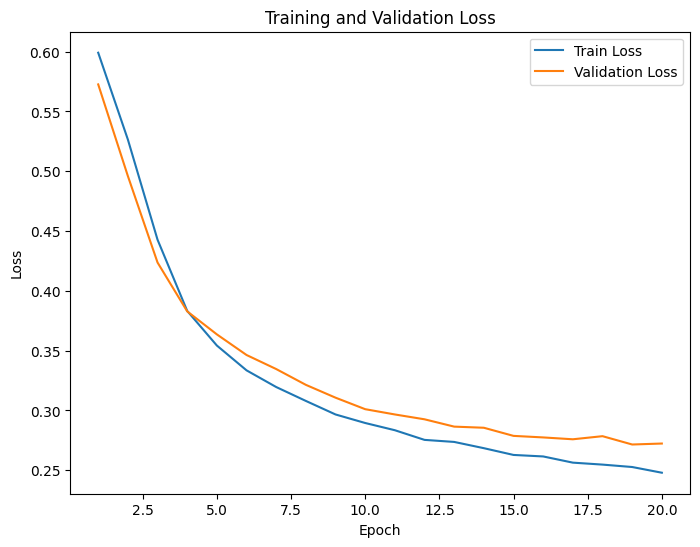

Final Test Accuracy: 0.8700


In [ ]:
# Visualize Training History
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Evaluate the model on the test set separately
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Final Test Accuracy: {correct / total:.4f}")


# Export the results to a Results Folder, and the model to a Model folder

In [ ]:
import os
import json

# Create a folder for model files
model_dir = "/content/drive/MyDrive/Colab Notebooks/Coursework/Model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Create a folder for other results
results_dir = "/content/drive/MyDrive/Colab Notebooks/Coursework/Results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Save model weights in the model folder
model_weights_path = os.path.join(model_dir, "model_weights.pth")
torch.save(model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

# Save the entire model (architecture + weights)
model_path = os.path.join(model_dir, "model.pth")
torch.save(model, model_path)
print(f"Entire model saved to {model_path}")

# Save training logs (train_losses and val_losses) in the results folder
logs = {
    "train_losses": train_losses,
    "val_losses": val_losses
}
logs_path = os.path.join(results_dir, "training_logs.json")
with open(logs_path, "w") as f:
    json.dump(logs, f)
print(f"Training logs saved to {logs_path}")

# Save final test accuracy in the results folder
final_accuracy = correct / total
accuracy_path = os.path.join(results_dir, "test_accuracy.txt")
with open(accuracy_path, "w") as f:
    f.write(f"Final Test Accuracy: {final_accuracy:.4f}\n")
print(f"Test accuracy saved to {accuracy_path}")

# Save the loss curve plot in the results folder
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plot_path = os.path.join(results_dir, "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve plot saved to {plot_path}")


Model weights saved to /content/drive/MyDrive/Colab Notebooks/Coursework/Model/model_weights.pth
Entire model saved to /content/drive/MyDrive/Colab Notebooks/Coursework/Model/model.pth
Training logs saved to /content/drive/MyDrive/Colab Notebooks/Coursework/Results/training_logs.json
Test accuracy saved to /content/drive/MyDrive/Colab Notebooks/Coursework/Results/test_accuracy.txt
Loss curve plot saved to /content/drive/MyDrive/Colab Notebooks/Coursework/Results/loss_curve.png
